In [95]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
from pennylane.optimize import AdamOptimizer
import sys


In [96]:
# np.random.seed(28)
# np.random.seed(32)
np.random.seed(14)

In [97]:
def random_oracle_builder(num_qubits):
    size = 2**num_qubits
    rand_vec = np.random.rand(size)

    # Generate indices for the zero elements
    num_zeros = np.random.randint(3,size)
    zero_indices = np.random.choice(size, num_zeros, replace=False)

    # Set the elements at the zero indices to zero
    rand_vec[zero_indices] = 0
    
    # invalid_state = '1'+(num_qubits-1)*'0'
    
    # invalid_state_index = 2**(num_qubits-1)
    # if(rand_vec[invalid_state_index]>0.00001):
    #     print('Oracle has invalid state -0')
    # rand_vec[invalid_state_index]=0
    
    rand_vec = rand_vec/np.linalg.norm(rand_vec)
    return rand_vec

# print(random_oracle_builder(2))

In [98]:
#Global Control Variables
k_helper = None
k_full_global_search_max = None
k_full_global_search_min = None
k_binary_global_search_max = None
k_binary_global_search_min = None

#Thresholds 
threshold_helper_u = 0.25
threshold_helper_l = -0.25
threshold_max = -0.7
threshold_min = 0.7
threshold_min_backtrack = -0.9
threshold_max_backtrack = 0.9


#Rates
global_search_rate_max = 2
global_search_rate_min = 2

#Devices
device_name_standard_maker = 'default.qubit'
device_global_search = 'default.qubit' 

# test_input = [0.6, 0.3, 0.0, 0.1, 0.5, 0.0,0.0,0.5,0.5,0.0,0.2,0,0.0,0.1, 0.8, 0.0]
# test_input = np.array(test_input)
# test_input = test_input/np.linalg.norm(test_input)

test_input = random_oracle_builder(num_qubits=4)


num_of_qubits_test = int(np.log2(len(test_input)))
num_overflow_bit = 2
num_qubits = num_of_qubits_test + num_overflow_bit


# start_state = np.array(test_input)
# start_state = start_state/np.linalg.norm(start_state)
start_state = test_input
print(start_state)

[0.         0.         0.         0.01151867 0.44336632 0.
 0.         0.45560292 0.77182874 0.         0.         0.
 0.         0.         0.         0.        ]


In [99]:
# Calculate global maximum and minimum (classical) for test purposes
cls_max_val = -2**num_of_qubits_test
cls_min_val = 2**num_of_qubits_test


for x in range(len(test_input)):
    bin_rep = np.binary_repr(x,num_of_qubits_test)
    print(bin_rep,': ',test_input[x])
    if(np.isclose(test_input[x],0)):
        continue

    if(bin_rep[0]=='1'):
        x=int(bin_rep,2)-(1<<num_of_qubits_test)
    if(x<cls_min_val):
        cls_min_val=x
    if(x>cls_max_val):
        cls_max_val=x

print(cls_max_val)
print(cls_min_val)


0000 :  0.0
0001 :  0.0
0010 :  0.0
0011 :  0.011518670034625486
0100 :  0.44336631588278835
0101 :  0.0
0110 :  0.0
0111 :  0.45560292248386114
1000 :  0.7718287421477136
1001 :  0.0
1010 :  0.0
1011 :  0.0
1100 :  0.0
1101 :  0.0
1110 :  0.0
1111 :  0.0
7
-8


In [100]:
def add_k_sign(k, wires):
    #sign handling
    bin_rep = np.binary_repr(k,len(wires))
    k = int(bin_rep,2)

    qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)

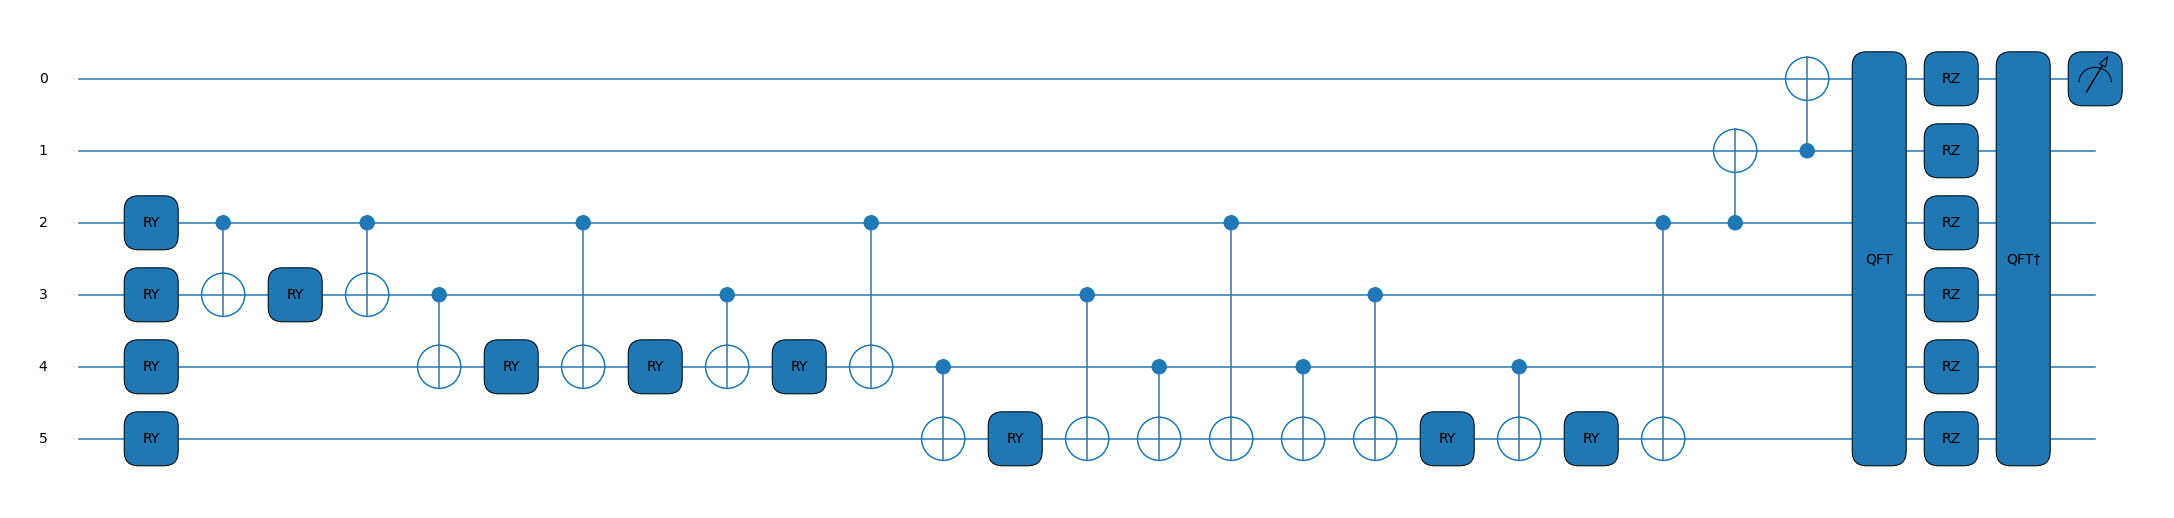

In [101]:
dev_standard_maker = qml.device(device_name_standard_maker, wires=num_qubits,shots=1024) 
@qml.qnode(dev_standard_maker)
def standard_maker_helper_circuit(k,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
     # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])
    add_k_sign(k,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))


qml.draw_mpl(standard_maker_helper_circuit, show_all_wires=True)(0,start_state,dev_standard_maker.wires)
plt.show()

K_helper :  7


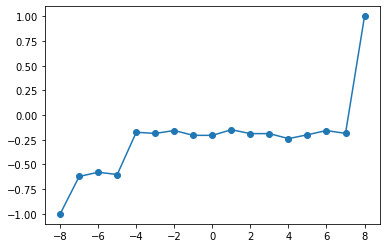

In [102]:

# x=[i for i in range(-2**(num_qubits-1-1),2**(num_qubits-1-1)+1)]
x=[i for i in range(-(2**(num_of_qubits_test-1)),2**(num_of_qubits_test-1)+1)]
y=[]
for i in x:
    exp_val = standard_maker_helper_circuit(i,start_state,dev_standard_maker.wires) 
    # print(i)
    # print(exp_val)
    if(threshold_helper_l<exp_val<threshold_helper_u):
        # print(i)
        k_helper = i

    y.append(exp_val)

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

if(k_helper==None):
    print('Error in standard making')

print('K_helper : ',k_helper)


In [103]:
while k_helper==None:
    exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
    if(exp_val<threshold_max):
        if(exp_val<threshold_max_backtrack):
            k_binary_global_search_max = -i_max_previous
        else:
            k_binary_global_search_max = -i_max
    else:
        i_max_previous = i_max
        i_max += int((size-i_max)/global_search_rate_max)+1

IndentationError: expected an indented block (2140882165.py, line 2)

In [ ]:
size_split = 2**(num_qubits-num_overflow_bit)-1
k_upper=0
k_lower=0


while k_upper==None and k_lower==None:
    if(exp_val<threshold_max):
        if(exp_val<threshold_max_backtrack):
            k_binary_global_search_max = -i_max_previous
        else:
            k_binary_global_search_max = -i_max
    else:
        i_max_previous = i_max
        i_max += int((size-i_max)/global_search_rate_max)+1
    
print('done')
i_min_previous = i_min            
while k_lower==None:
    exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
    if(exp_val>threshold_min):
        if(exp_val>threshold_min_backtrack):
            k_binary_global_search_min = i_min_previous
        else:
            k_binary_global_search_min = i_min
    else:
        i_min_previous = i_min
        i_min += int((size-i_min)/global_search_rate_min)+1

In [ ]:
dev_global_search = qml.device(device_global_search, wires=num_qubits,shots=1024) 
@qml.qnode(dev_global_search)
def global_search(k_new,k_helper,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
    # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])     
    add_k_sign(k_helper+k_new,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))

In [ ]:
# # Full Global Search
# size = 2**(num_qubits-num_overflow_bit)-1

# plt_x_max=[i for i in reversed(range(-size,1))]
# plt_y_max = []

# plt_x_min = [i for i in range(0,size+1)]
# plt_y_min = []

# i_max=0
# i_min=0

# fmax_flag = False
# while i_max<=size:
#     exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
#     plt_y_max.append(exp_val)
#     if(threshold_max>exp_val and not fmax_flag):
#         k_full_global_search_max = -i_max
#         fmax_flag = True
#     i_max+=1

        
# fmin_flag = False       
# while i_min<=size:
#     exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
#     plt_y_min.append(exp_val)
#     if(exp_val>threshold_min and not fmin_flag):
#         k_full_global_search_min = i_min
#         fmin_flag = True
#     i_min += 1

# #TODO:find alternative
# k_full_global_search_max +=1
# k_full_global_search_min -=1

In [ ]:
def classical_vqs_result_optimal_finder(vqs_res):
    cls_max_val = -2**num_of_qubits_test
    cls_min_val = 2**num_of_qubits_test
    #TODO invalid state handling ?
    for x in vqs_res:
        val = x[0]
        if(val<cls_min_val):
            cls_min_val=val
        if(val>cls_max_val):
            cls_max_val=val
    return {'min':cls_min_val,'max':cls_max_val}


In [ ]:
# plt.scatter(plt_x_max, plt_y_max)
# plt.plot(plt_x_max, plt_y_max)


# plt.scatter(plt_x_min, plt_y_min)
# plt.plot(plt_x_min, plt_y_min)


# if k_full_global_search_max == None:
#     print('Error in finding global max')
# if k_full_global_search_min == None:
#     print('Error in finding global min')

    
# print('k_helper = ',k_helper)
# print('k_full_global_search_max= ',k_full_global_search_max)
# print('k_full_global_search_min= ',k_full_global_search_min)
# print('vqs_res_min= ',vqs_res_min)
# print('vqs_res_max= ',vqs_res_max)

# q_max_val = -(k_helper+k_full_global_search_max) + vqs_res_max
# q_min_val = -(k_helper+k_full_global_search_min) + vqs_res_min


# # print('=========================================')
# # print('Quantum Solution for Max (without VQS) = ',q_max_val)
# # print('Quantum Solution for Min (without VQS) = ',q_min_val)

# print('+++++++++++++++++++++++++++++++++++++++++')
# print('Quantum Solution for Max (with VQS) = ',q_max_val)
# print('Quantum Solution for Min (with VQS) = ',q_min_val)

# print('Classical Solution for Max: ',cls_max_val)
# print('Classical Solution for Min: ',cls_min_val)

In [ ]:
# Binary Search
size = 2**(num_qubits-num_overflow_bit)-1
i_max=0
i_min=0

i_max_previous = i_max
while k_binary_global_search_max==None:
    exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
    if(exp_val<threshold_max):
        if(exp_val<threshold_max_backtrack):
            k_binary_global_search_max = -i_max_previous
        else:
            k_binary_global_search_max = -i_max
    else:
        i_max_previous = i_max
        i_max += int((size-i_max)/global_search_rate_max)+1
    
print('done')
i_min_previous = i_min            
while k_binary_global_search_min==None:
    exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
    if(exp_val>threshold_min):
        if(exp_val>threshold_min_backtrack):
            k_binary_global_search_min = i_min_previous
        else:
            k_binary_global_search_min = i_min
    else:
        i_min_previous = i_min
        i_min += int((size-i_min)/global_search_rate_min)+1




I =  0
EXP_VAL  -0.1875
I =  -8
EXP_VAL  -0.1796875
I =  -12
EXP_VAL  -0.572265625
I =  -14
EXP_VAL  -0.576171875
I =  -15
EXP_VAL  -1.0
done


In [ ]:
# !pip install pennylane
# !pip install pennylane-qiskit
# !pip install pennylane-lightning
# !pip install pennylane-lightning[gpu]  # has erro

import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

# print(k_helper)
# print(k_full_global_search_min)
#VQS + full search
shift_max = k_helper+k_binary_global_search_max

# global_shift_min = 0

# print(start_state)
# print(num_qubits)
# print(num_overflow_bit)
# print(global_shift_min)

# vqs
num_qubit_vqs = 1+num_qubits
eps_val_q = 1/math.sqrt(2**num_qubit_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

print_circuit_flag = False

N = 2**(num_qubit_vqs-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_qubit_vqs-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_qubit_vqs-1)

# initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0, 0.5, 0.5])
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0,
#                         0.0, 0.2, 0.0, 0.4, 0.3, 0.0, 0.0, 0.5, 0.0, 0.0])
# start_state = start_state/np.linalg.norm(start_state)
initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
# initial_state_0_phi1 = initial_state_phi1 + \
#     [0]*len(initial_state_phi1)  # 2**num_qubit_vqs


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

# print(np.arange(1, 10, 3))
# print(np.linspace(1, 10, 4))
# print(list(range(10)))

device_name = 'default.qubit'  # 'default.qubit' #
device_name2 = 'default.qubit'  # has qml.state()


def oracle_builder_for_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
        1+num_overflow_bit, num_qubit_vqs))
    
    # add some bits for handle overflow
    for w in reversed(range(2, num_overflow_bit+2)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_max, wires=range(1, num_qubit_vqs))

    

def oracle_builder_for_no_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
       num_overflow_bit, num_qubit_vqs-1))
    # add some bits for handle overflow
    for w in reversed(range(1, num_overflow_bit+1)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_max, wires=range(0, num_qubit_vqs-1))


def layer_t3_no_HT(theta, qubit_posi):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # length of qubit_posi: num_qubit_vqs-1
    # number of wires: num_qubit_vqs
    

    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i+num_qubit_vqs-1], wires=(qubit_posi[i]))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
#     qml.ctrl(qml.PauliZ(qubit_posi[0]), qubit_posi[-1]) # CZ struct2
    qml.CNOT(wires=(qubit_posi[-1], qubit_posi[0]))  # CNOT struct3


def layer_t3_with_HT(theta, num_qubit_vqs):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # number of wires: num_qubit_vqs
    
    
    
    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i], wires=(0, i+1))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3

    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i+num_qubit_vqs-1], wires=(0, i+1))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3
#     qml.ctrl(qml.PauliZ(1), (0, num_qubit_vqs-1)) # CZ struct2
    qml.Toffoli(wires=(0, num_qubit_vqs-1, 1))  # CCNOT struct3



# dev_with_HT=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HT = qml.device(device_name, wires=num_qubit_vqs)


@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    qml.PauliX(wires=1) #MAX
    
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print(qml.draw(quantum_circuit_with_HT)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_qubit_vqs-1)]))


# dev_with_HTZ=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HTZ = qml.device(device_name, wires=num_qubit_vqs)


@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    qml.PauliX(wires=1) #MAX

    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.CZ([0, 1])
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print('newly added')
    print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_qubit_vqs-1)]))


# dev_no_HT_Z=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z = qml.device(device_name, wires=num_qubit_vqs-1)


@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()
    qml.PauliX(wires=0) #MAX

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    
    qml.PauliX(wires=0) #MAX

    return qml.expval(qml.PauliZ(0))

    # return qml.sample(qml.PauliZ(0))
if(print_circuit_flag):
    print('newly added 2')
    print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_qubit_vqs-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, backend='qasm_simulator')
dev_no_HT_S = qml.device(device_name2, wires=num_qubit_vqs-1)


@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()
    qml.PauliX(wires=0) #MAX
    
    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    qml.PauliX(wires=0) #MAX    
        
    return qml.state()


if(print_circuit_flag):
    print('newly added 3')


val_global = []
coef2 = 1


def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append(
        [val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    
    return obj


max_repeat = 1  # 100
iter_max = 300  # 300
num_of_layers = 3
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []

vqs_results_max = []


debug_flag, print_flag = 0, True


start_time = datetime.datetime.now()

for rep in range(1, max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')

    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta = qml_np.random.uniform(
        0, 2*math.pi, size=(num_of_layers, 2*(num_qubit_vqs-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate = iter_max
    for iter in range(1, iter_max+1):
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter >= 2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            #val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            #val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val:  # eps_val=1e-10
            if abs((val1-val1_old)/val1) < tiny_change_threshold:  # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change:  # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter == 1 or iter % 50 == 0 or iter == iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
            #      :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
            #      :: theta={theta}')

        obj_list.append(obj)
        if break_flag:
            iter_terminate = iter
            break
    theta_list.append(theta)
    # print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)

    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')

    # print('val_global=')
    # print(val_global)
    val_global = []  # reset to empty

    # display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]

    # print(f'state={state}')
    if len(prb) > 20:
        print(f'prb(last 2)={prb[-2:]}')
    else:
        print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])

    for i in range(len(prb)):
        if(np.linalg.norm(prb[i]) > 0.01):
            index_sign_decimal = int(np.binary_repr(i, num_qubit_vqs-1),2) #MAX
            vqs_results_max.append((index_sign_decimal,np.binary_repr(i, num_qubit_vqs-1), np.linalg.norm(prb[i])))

# print('theta_list=', theta_list)6
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()

print(f'time consumed: {duration_in_s}s')
print(vqs_results_max)

initial_state_phi1=[0.0, 0.0, 0.0, 0.011518670034625486, 0.44336631588278835, 0.0, 0.0, 0.45560292248386114, 0.7718287421477136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


rep=1
iter=  1 :: obj=  0.35829656 :: val1_1=  0.42399528 :: val1_2=  1.14058840 :: -0.5*(val1_1 - val1_2)=  0.35829656
iter= 50 :: obj= -2.50973130 :: val1_1=  2.83494260 :: val1_2= -2.18452000 :: -0.5*(val1_1 - val1_2)= -2.50973130
time consumed: 14.478244s, after for-iter
prb(last 2)=[(0.0011442003189703637-0.00093902093423821j), (3.752678585122349e-08-3.0797437236648186e-08j)]
time consumed: 14.528042s
[(0, '000000', 0.9567962034407769)]


In [ ]:
# !pip install pennylane
# !pip install pennylane-qiskit
# !pip install pennylane-lightning
# !pip install pennylane-lightning[gpu]  # has erro

import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

# print(k_helper)
# print(k_full_global_search_min)
#VQS + full search
shift_min = k_helper+k_binary_global_search_min

# global_shift_min = 0

# print(start_state)
# print(num_qubits)
# print(num_overflow_bit)
# print(global_shift_min)

# vqs
num_qubit_vqs = 1+num_qubits
eps_val_q = 1/math.sqrt(2**num_qubit_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

print_circuit_flag = False

N = 2**(num_qubit_vqs-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_qubit_vqs-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_qubit_vqs-1)

# initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0, 0.5, 0.5])
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0,
#                         0.0, 0.2, 0.0, 0.4, 0.3, 0.0, 0.0, 0.5, 0.0, 0.0])
# start_state = start_state/np.linalg.norm(start_state)
initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
# initial_state_0_phi1 = initial_state_phi1 + \
#     [0]*len(initial_state_phi1)  # 2**num_qubit_vqs


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

# print(np.arange(1, 10, 3))
# print(np.linspace(1, 10, 4))
# print(list(range(10)))

device_name = 'default.qubit'  # 'default.qubit' #
device_name2 = 'default.qubit'  # has qml.state()


def oracle_builder_for_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
        1+num_overflow_bit, num_qubit_vqs))
    
    # add some bits for handle overflow
    for w in reversed(range(2, num_overflow_bit+2)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_min, wires=range(1, num_qubit_vqs))

def oracle_builder_for_no_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
       num_overflow_bit, num_qubit_vqs-1))
    # add some bits for handle overflow
    for w in reversed(range(1, num_overflow_bit+1)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_min, wires=range(0, num_qubit_vqs-1))
    

def layer_t3_no_HT(theta, qubit_posi):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # length of qubit_posi: num_qubit_vqs-1
    # number of wires: num_qubit_vqs
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i+num_qubit_vqs-1], wires=(qubit_posi[i]))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
#     qml.ctrl(qml.PauliZ(qubit_posi[0]), qubit_posi[-1]) # CZ struct2
    qml.CNOT(wires=(qubit_posi[-1], qubit_posi[0]))  # CNOT struct3


def layer_t3_with_HT(theta, num_qubit_vqs):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # number of wires: num_qubit_vqs
    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i], wires=(0, i+1))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3

    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i+num_qubit_vqs-1], wires=(0, i+1))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3
#     qml.ctrl(qml.PauliZ(1), (0, num_qubit_vqs-1)) # CZ struct2
    qml.Toffoli(wires=(0, num_qubit_vqs-1, 1))  # CCNOT struct3





# dev_with_HT=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HT = qml.device(device_name, wires=num_qubit_vqs)


@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    
    
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print(qml.draw(quantum_circuit_with_HT)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_qubit_vqs-1)]))


# dev_with_HTZ=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HTZ = qml.device(device_name, wires=num_qubit_vqs)


@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()

    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.CZ([0, 1])
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print('newly added')
    print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_qubit_vqs-1)]))


# dev_no_HT_Z=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z = qml.device(device_name, wires=num_qubit_vqs-1)


@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))

    return qml.expval(qml.PauliZ(0))

    # return qml.sample(qml.PauliZ(0))
if(print_circuit_flag):
    print('newly added 2')
    print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_qubit_vqs-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, backend='qasm_simulator')
dev_no_HT_S = qml.device(device_name2, wires=num_qubit_vqs-1)


@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    return qml.state()


if(print_circuit_flag):
    print('newly added 3')


val_global = []
coef2 = 1


def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append(
        [val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    
    return obj


max_repeat = 1  # 100
iter_max = 300  # 300
num_of_layers = 3
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []

vqs_results_min = []


debug_flag, print_flag = 0, True


start_time = datetime.datetime.now()

for rep in range(1, max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')

    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta = qml_np.random.uniform(
        0, 2*math.pi, size=(num_of_layers, 2*(num_qubit_vqs-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate = iter_max
    for iter in range(1, iter_max+1):
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter >= 2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            #val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            #val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val:  # eps_val=1e-10
            if abs((val1-val1_old)/val1) < tiny_change_threshold:  # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change:  # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter == 1 or iter % 50 == 0 or iter == iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
            #      :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
            #      :: theta={theta}')

        obj_list.append(obj)
        if break_flag:
            iter_terminate = iter
            break
    theta_list.append(theta)
    # print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)

    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')

    # print('val_global=')
    # print(val_global)
    val_global = []  # reset to empty

    # display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]

    # print(f'state={state}')
    if len(prb) > 20:
        print(f'prb(last 2)={prb[-2:]}')
    else:
        print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])

    for i in range(len(prb)):
        if(np.linalg.norm(prb[i]) > 0.01):
            index_sign_decimal = int(np.binary_repr(i, num_qubit_vqs-1),2)-(1<<num_qubits)
            vqs_results_min.append((index_sign_decimal,np.binary_repr(i, num_qubit_vqs-1), np.linalg.norm(prb[i])))

# print('theta_list=', theta_list)6
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()

print(f'time consumed: {duration_in_s}s')
print(vqs_results_min)

initial_state_phi1=[0.0, 0.0, 0.0, 0.011518670034625486, 0.44336631588278835, 0.0, 0.0, 0.45560292248386114, 0.7718287421477136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


rep=1
iter=  1 :: obj= -0.36909339 :: val1_1=  0.56653261 :: val1_2= -0.17165417 :: -0.5*(val1_1 - val1_2)= -0.36909339
iter= 50 :: obj= -4.12599335 :: val1_1=  4.06382183 :: val1_2= -4.18816488 :: -0.5*(val1_1 - val1_2)= -4.12599335
time consumed: 18.3876s, after for-iter
prb(last 2)=[(2.718195707170992e-05+2.2307655661784426e-05j), (0.7718350086489179+0.6334286216172287j)]
time consumed: 18.429128s
[(-1, '111111', 0.9984793935079368)]


In [ ]:
vqs_res_min = classical_vqs_result_optimal_finder(vqs_res=vqs_results_min)['min']
vqs_res_max = classical_vqs_result_optimal_finder(vqs_res=vqs_results_max)['max']
print("vqs_res_min: ",vqs_res_min)
print("vqs_res_max: ",vqs_res_max)
print('=========================================')


if k_binary_global_search_max == None:
    print('Error in finding global max binary')
if k_binary_global_search_min == None:
    print('Error in finding global min binary')

    
print('k_helper= ',k_helper)
print('k_binary_global_search_max= ',k_binary_global_search_max)
print('k_binary_global_search_min= ',k_binary_global_search_min)

qbs_max_val = -(k_helper+k_binary_global_search_max) + vqs_res_max
qbs_min_val = -(k_helper+k_binary_global_search_min) + vqs_res_min

print('=========================================')
print('Quantum Solution for Max= ',qbs_max_val)
print('Quantum Solution for Min= ',qbs_min_val)

print('Classical Solution for Max: ',cls_max_val)
print('Classical Solution for Min: ',cls_min_val)

vqs_res_min:  -1
vqs_res_max:  0
k_helper=  7
k_binary_global_search_max=  -14
k_binary_global_search_min=  0
Quantum Solution for Max=  7
Quantum Solution for Min=  -8
Classical Solution for Max:  7
Classical Solution for Min:  -8
